# DWM project - Explorative Data Analysis & Data preparation

In [163]:
# Import useful libraries
import pandas as pd
from sys import getsizeof
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sb
from texttable import Texttable
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

env = 'dev'  # possible values: 'dev' for development, 'prod' for production
dropped = []  # to keep track of the dropped columns, to repeat the same process on test dataset. After every drop remember to add dropped columns to this list

The aim of this notebook is to 
- understand the data structure 
- understand all possible issues on the data that can compromise the model creation phase
- try to solve the aforementioned issues
- prepare in general the data for the analysis

In order to make this analysis as clear and self-explanatory as possible, I'll try describe the whole process and choices I take as best as I can, also by using graphical representations whenever possible.

Many ideas on graphs are taken from the professor classes, kaggle competitions and from the internet, especially from Towards Data Science and implemented with the help of my best friend, Stack Overflow and Pandas documentation.

### Data import and concatenation
I concatenate all properties data into a dataframe and all transaction data into another.
The analysis is done on all properties and all transactions joined together, because
1. it's the data on which the models are trained
2. anyhow, I'm not able to consider the whole `properties` dataset due to the lack of powerful hardware to make the computation, I take only a part of the whole dataset.
    This was decided after having found that the time for even easy computation was too long.

This of course came at the cost of considerations and models that can be not as good as the ones created with the whole dataset; however the process is the same.

In [164]:
# Read data
n = 700000
properties_2016 = pd.read_csv("../DWMProjectData/properties_2016.csv", nrows=n)
properties_2017 = pd.read_csv("../DWMProjectData/properties_2017.csv", nrows=n)
transactions_2016 = pd.read_csv("../DWMProjectData/train_2016_v2.csv")
transactions_2017 = pd.read_csv("../DWMProjectData/train_2017.csv")

A warning is raised due to some columns of type object and with NaN value: I'll handle this later.

In [165]:
# Merge the properties datasets
properties = pd.concat([properties_2016, properties_2017], axis=0,
                       ignore_index=True)  # need to set ignore_index=True to change indexes to avoid hereafter problems
transactions = pd.concat([transactions_2016, transactions_2017], axis=0, ignore_index=True)

### Dataset `properties` exploration
A little cleaning before joining the two datasets
I can imagine that some houses are repeated on the dataset of 2016 and 2017. In order to save memory, it's a good idea to keep only one house if they are exacly the same.

In [166]:
# Drop duplicates on concatenated property dataset
print(f"#Properties rows before duplicate removal: {properties.shape[0]}")
properties.drop_duplicates(keep='first', inplace=True)
print(f"#Properties rows after duplicate removal: {properties.shape[0]}")
print(
    f"Properties has {properties.duplicated(subset=['parcelid'], keep=False).sum()} houses repeated with differents attributes [{round(properties.duplicated(subset=['parcelid'], keep=False).sum() * 100 / properties.shape[0], 2)}% of data]")

#Properties rows before duplicate removal: 1400000
#Properties rows after duplicate removal: 1399153
Properties has 1392864 houses repeated with differents attributes [99.55% of data]


It seems that many houses are repeated, but with different values in some columns. Let's have a look on some record in order to have a more clear idea on what's happening:

In [167]:
properties[properties.duplicated(subset=['parcelid'], keep=False)].sort_values(by='parcelid').iloc[0:10]

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
1265456,10711725,1.0,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,209000.0,701000.0,2016,492000.0,8625.75,NaN,NaN,6.037113e+13
563784,10711725,1.0,NaN,NaN,3.0,4.0,NaN,4.0,3.0,NaN,...,NaN,NaN,183000.0,615000.0,2015,432000.0,8625.75,NaN,NaN,6.037113e+13
1205671,10711730,1.0,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,180866.0,287771.0,2016,106905.0,3682.27,NaN,NaN,6.037113e+13
504167,10711730,1.0,NaN,NaN,3.0,4.0,NaN,4.0,3.0,NaN,...,NaN,NaN,178150.0,283450.0,2015,105300.0,3682.27,NaN,NaN,6.037113e+13
355489,10711735,1.0,NaN,NaN,3.0,4.0,NaN,4.0,3.0,NaN,...,NaN,NaN,174760.0,273120.0,2015,98360.0,3529.03,NaN,NaN,6.037113e+13
1056564,10711735,1.0,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,177425.0,277284.0,2016,99859.0,3529.03,NaN,NaN,6.037113e+13
907331,10711740,1.0,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,186572.0,453983.0,2016,267411.0,5654.12,NaN,NaN,6.037113e+13
206705,10711740,1.0,NaN,NaN,3.0,4.0,NaN,4.0,3.0,NaN,...,NaN,NaN,183770.0,447165.0,2015,263395.0,5654.12,NaN,NaN,6.037113e+13
758273,10711745,1.0,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,240700.0,464597.0,2016,223897.0,5863.18,NaN,NaN,6.037113e+13
58104,10711745,1.0,NaN,NaN,3.0,4.0,NaN,4.0,3.0,NaN,...,NaN,NaN,237085.0,457619.0,2015,220534.0,5863.18,NaN,NaN,6.037113e+13


We can notice that many houses are duplicated; some houses are exactly the same over 2016 and 2017 and other has changed. Taking a brief look at the data, the changes mainly involve columns like `structuretaxdollarcnt`, `taxvaluedollarcnt` and `landtaxvaluedollarcnt`, that is normal that change over the years.
I came at the conclusion that this duplicated but slightly different rows can be both removed and keep, for different reasons:
- it's a good idea to remove them because you basically have half the data to manage, but at the same time
- it's a good idea to keep them in order to have a better prediction over different years

I go for the second option, since the aim of the project is give predictions for different time periods.

### Data join
Now I can perform data join

In [168]:
# Dataset join
data = pd.merge(left=properties, right=transactions, how='inner', on='parcelid')

# Delete datasets that I'll not use to save memory
del properties_2016, properties_2017, transactions_2016, transactions_2017, properties, transactions

### Data splitting in train, validation, test
To avoid cheating, i.e. making consideration, cleaning and building a model on the whole dataset and then test on the same data, I first split the data and from now I'll make my observations on the train dataset only. I can consider the achieved results quite good, since the train dataset is a big portion of the whole data, so a good sample.

Then, at the end of the data analysis and cleaning on train dataset, I'll perform the same cleaning and transformation on the other datasets, in order to have a coherent input to give to the model that will be build.

In [169]:
# Data splitting in train, validation, test
train_size = 0.7  # validation and test is the remaining equally divided

X = data.drop(columns=['logerror']).copy()
y = data['logerror'].copy()
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=train_size)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

del data, X, y, X_rem, y_rem

## Explorative analysis of `data` dataset with data cleaning and preparation

### Analysis on rows: find out the rows that has more than `threshold` missing values

I keep only rows with a decent number of defined values, since if a row has too missing values is not a good sample to build the model

In [170]:
threshold = 0.5  # seems a good compromise

print(
    f"#rows before: {X_train.shape[0]} | Mean is {round((X_train.isna().sum(axis=1) / X_train.shape[1]).mean() * 100, 2)}% missing values per row")

train = pd.concat([X_train, y_train], axis=1)
train = train[train.isnull().sum(axis=1) / train.shape[1] < threshold] # remove in X
col_t = train.columns.to_list()
col_t.remove('logerror')
X_train = train.loc[:,col_t].copy()
y_train = train.loc[:, 'logerror'].copy()
del train, col_t

print(
    f"#rows after:  {X_train.shape[0]} | Mean is {round((X_train.isna().sum(axis=1) / X_train.shape[1]).mean() * 100, 2)}% missing values per row")

#rows before: 54953 | Mean is 47.53% missing values per row
#rows after:  45383 | Mean is 46.5% missing values per row


### Analysis on column names
I notice from columns names that some columns has similar names and I suspect that can contain the same information or are different classification system for the same things. I try to figure it out:

In [171]:
group_pool = ['pooltypeid10', 'pooltypeid2', 'pooltypeid7']
group_sqft = ['finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
              'finishedsquarefeet6']
group_bath = ['fullbathcnt', 'calculatedbathnbr', 'fullbathcnt', 'threequarterbathnbr']

if env != 'dev':
    to_test = 10000  # I don't test on all the dataset since it takes lot of time
    n_ok = 0  # for n_ok I mean the number of rows that satisfy the condition: row with one unique value (i.e. all are null or there is only one unique value (not counting nan))
    n_no = 0  # for n_no I mean all the rows that doesn't satisfy the ok condition
    for r in X_train.index[0:to_test]:
        if X_train.loc[r][group_pool].isna().sum() == len(group_pool) or X_train.loc[r][group_pool].nunique() == 1:
            n_ok += 1
        else:
            n_no += 1
    print(f"POOL: #ok: {n_ok} | #no: {n_no}")

    n_ok = 0  # for n_ok I mean the number of rows that satisfy the condition: row with one unique value (i.e. all are null or there is only one unique value (not counting nan))
    n_no = 0  # for n_no I mean all the rows that doesn't satisfy the ok condition
    for r in X_train.index[0:to_test]:
        if X_train.loc[r][group_sqft].isna().sum() == len(group_sqft) or X_train.loc[r][group_sqft].nunique() == 1:
            n_ok += 1
        else:
            n_no += 1
    print(f"SQFT: #ok: {n_ok} | #no: {n_no}")

    n_ok = 0  # for n_ok I mean the number of rows that satisfy the condition: row with one unique value (i.e. all are null or there is only one unique value (not counting nan))
    n_no = 0  # for n_no I mean all the rows that doesn't satisfy the ok condition
    for r in X_train.index[0:to_test]:
        if X_train.loc[r][group_bath].isna().sum() == len(group_bath) or X_train.loc[r][group_bath].nunique() == 1:
            n_ok += 1
        else:
            n_no += 1
    print(f"BATH: #ok: {n_ok} | #no: {n_no}")

It seems that not alway but very often the columns share the same content, so I think it's a good idea to merge the column inside each group together.
Let's do it:

In [172]:
to_drop = ['pooltypeid10', 'pooltypeid7', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
           'finishedsquarefeet50', 'calculatedbathnbr', 'fullbathcnt', 'threequarterbathnbr']
# Merge pools: I only keep pooltypeid2
X_train['pooltypeid2'] = X_train.apply(
    lambda row: row.loc[group_pool].dropna(how='all').unique().max()
    if row.loc[group_pool].nunique(dropna=True) >= 1
    else row.loc[group_pool][0], axis=1)

# Merge sqft: I only keep finishedsquarefeet6
X_train['finishedsquarefeet6'] = X_train.apply(
    lambda row: row.loc[group_sqft].dropna(how='all').unique().max()
    if row.loc[group_sqft].nunique(dropna=True) >= 1
    else row.loc[group_sqft][0], axis=1)

# Merge bath: I only keep fullbathcnt
X_train['fullbathcnt'] = X_train.apply(
    lambda row: row.loc[group_bath].dropna(how='all').unique().max()
    if row.loc[group_bath].nunique(dropna=True) >= 1
    else row.loc[group_bath][0], axis=1)

X_train.drop(columns=to_drop, inplace=True)

dropped.append(to_drop)

###  Missing values (aka NaN) managment
Let's visualize the percentual of missing values for each column. To avoid to print all column, I set a threshold.
I think it can be a good idea to remove some column that have really few data and for which I have no good idea on how to fill the NaN with intelligent values.

In [173]:
threshold = 0.90
t = Texttable()
t.add_rows([['Column', '% missing values']])
for col in X_train.columns:
    current_threshold = X_train[col].isna().sum() / X_train.shape[0]
    if current_threshold > threshold:
        t.add_row([col, f'{round(current_threshold * 100, 2)}%'])
print(t.draw())

+--------------------------+------------------+
|          Column          | % missing values |
+==========================+==================+
| architecturalstyletypeid | 99.67%           |
+--------------------------+------------------+
| basementsqft             | 99.95%           |
+--------------------------+------------------+
| buildingclasstypeid      | 99.97%           |
+--------------------------+------------------+
| decktypeid               | 99.11%           |
+--------------------------+------------------+
| finishedfloor1squarefeet | 90.54%           |
+--------------------------+------------------+
| hashottuborspa           | 97.24%           |
+--------------------------+------------------+
| poolsizesum              | 98.67%           |
+--------------------------+------------------+
| storytypeid              | 99.95%           |
+--------------------------+------------------+
| typeconstructiontypeid   | 99.62%           |
+--------------------------+------------

I remove `architecturalstyletypeid`, `basementsqft`, `buildingclasstypeid`, `decktypeid`, `storytypeid`, `typeconstructiontypeid`, `yardbuildingsqft17`, `yardbuildingsqft26`, `taxdelinquencyflag`, `taxdelinquencyyear`.
I keep the other because they can be useful.

We can summarize the problem of filling the NaN as
- Does the absence of the value mean that the value is 0? OR
- Does the absence of the value mean that that value was not registered while evaluating the house?

Methods:
- for some columns is trivial; for example, for pool, NaN will become 0, because we are quite sure that that house doesn't have a pool, since a pool is an important feature and must be taken into account while evaluating an house. I'll call this categories `fill_zero` in the code and I'll fill with zero this columns
- for others such as sqft areas, it'll be harder. Indeed here we cannot set `finishedfloor` as 0, because a house with 0sqft of finished floor have no sense, so I need to estimate the value, for example by setting it as the mean of the observations. A better estimation can be done by creating a model that finds the most similar houses and approximate the price as the mean of that, but let's keep it simple for now, since I'll have the opportunity to create some model in the second part of this project.
 Here I distinguish two types of columns:
    - categorical columns, that will be filled with mode of that column
    - numerical columns, that will be filled with mean of that column
- in some cases such as latitude and longitude, I don't have any good idea on how to manage them, so I'll drop them

In [174]:
#print(properties.columns[ properties.isna().any()].tolist())

fill_zero = ['fireplacecnt', 'fireplaceflag', 'garagecarcnt', 'garagetotalsqft',
             'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid2']
fill_categorical = ['airconditioningtypeid', 'buildingqualitytypeid', 'fips', 'heatingorsystemtypeid',
                    'propertycountylandusecode', 'propertylandusetypeid',
                    'propertyzoningdesc', 'rawcensustractandblock', 'censustractandblock', 'regionidcounty',
                    'regionidcity', 'regionidzip', 'regionidneighborhood',
                    'unitcnt']
fill_numerical = ['bathroomcnt', 'bedroomcnt', 'finishedfloor1squarefeet',
                  'calculatedfinishedsquarefeet', 'finishedsquarefeet6', 'lotsizesquarefeet', 'numberofstories',
                  'roomcnt', 'yearbuilt', 'taxvaluedollarcnt', 'structuretaxvaluedollarcnt',
                  'landtaxvaluedollarcnt', 'taxamount', 'assessmentyear']
to_drop = ['latitude', 'longitude', 'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid',
           'storytypeid', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'taxdelinquencyflag',
           'taxdelinquencyyear']

print(f"#columns before: {X_train.shape[1]}")

for c in fill_zero:
    X_train[c].fillna(value=0, inplace=True)
for c in fill_numerical:
    X_train[c].fillna(value=round(X_train[c].mean()), inplace=True)
for c in fill_categorical:
    X_train[c].fillna(value=X_train[c].mode()[0], inplace=True)
X_train.drop(columns=to_drop, inplace=True)
dropped.append(to_drop)

# print(len(fill_categorical) + len(fill_numerical) + len(to_drop) + len(fill_zero) + 1)
print(f"#columns after: {X_train.shape[1]}")

#columns before: 50
#columns after: 38


### Types exploration
I print all the types of the columns to make sure there is no unusual or strange type to deal with

In [175]:
for col in X_train.columns:
    print(f"{X_train.columns.get_loc(col)} | {col}: {X_train[col].dtype}")

0 | parcelid: int64
1 | airconditioningtypeid: float64
2 | bathroomcnt: float64
3 | bedroomcnt: float64
4 | buildingqualitytypeid: float64
5 | finishedfloor1squarefeet: float64
6 | calculatedfinishedsquarefeet: float64
7 | finishedsquarefeet6: float64
8 | fips: int64
9 | fireplacecnt: float64
10 | garagecarcnt: float64
11 | garagetotalsqft: float64
12 | hashottuborspa: object
13 | heatingorsystemtypeid: float64
14 | lotsizesquarefeet: float64
15 | poolcnt: float64
16 | poolsizesum: float64
17 | pooltypeid2: float64
18 | propertycountylandusecode: object
19 | propertylandusetypeid: int64
20 | propertyzoningdesc: object
21 | rawcensustractandblock: float64
22 | regionidcity: float64
23 | regionidcounty: int64
24 | regionidneighborhood: float64
25 | regionidzip: float64
26 | roomcnt: float64
27 | unitcnt: float64
28 | yearbuilt: float64
29 | numberofstories: float64
30 | fireplaceflag: object
31 | structuretaxvaluedollarcnt: float64
32 | taxvaluedollarcnt: float64
33 | assessmentyear: int

Types are int64, float64 and object. They are ok but some type cast work can be done.

### Type cast
I think it's a good idea to switch from int64 and float64 to int32 since the ensure enough precision for the task we are required to perform.
The only measurement that might require a float precision are the areas, but since they are measured in sqft, a change of a single unit in sqft is detailed enough for the aim of the project

In [176]:
print(f"size of properties before: {round(getsizeof(X_train) / 1000000, 2)} MB")

# cast types
for col in X_train.columns:
    if X_train[col].dtype == 'int64' or X_train[col].dtype == 'float64':
        print(f"convert {col} to int32")
        X_train[col] = X_train[col].astype('int32')
    else:
        print(f"skip {col}")

print(f"size of properties after: {round(getsizeof(X_train) / 1000000, 2)} MB")

size of properties before: 23.88 MB
convert parcelid to int32
convert airconditioningtypeid to int32
convert bathroomcnt to int32
convert bedroomcnt to int32
convert buildingqualitytypeid to int32
convert finishedfloor1squarefeet to int32
convert calculatedfinishedsquarefeet to int32
convert finishedsquarefeet6 to int32
convert fips to int32
convert fireplacecnt to int32
convert garagecarcnt to int32
convert garagetotalsqft to int32
skip hashottuborspa
convert heatingorsystemtypeid to int32
convert lotsizesquarefeet to int32
convert poolcnt to int32
convert poolsizesum to int32
convert pooltypeid2 to int32
skip propertycountylandusecode
convert propertylandusetypeid to int32
skip propertyzoningdesc
convert rawcensustractandblock to int32
convert regionidcity to int32
convert regionidcounty to int32
convert regionidneighborhood to int32
convert regionidzip to int32
convert roomcnt to int32
convert unitcnt to int32
convert yearbuilt to int32
convert numberofstories to int32
skip fireplac

The saved space is significant, so maybe I can use this space to upload more data in order to have better models.

### Objects handle
Let's see what are the objects and what's inside

In [177]:
for o in X_train.columns:
    if X_train[o].dtype == 'object':
        if X_train[o].nunique(dropna=False) < 10:
            print(f"{o.upper()} (#unique={X_train[o].nunique(dropna=False)}) {X_train[o].unique()}")
        else:
            print(f"{o.upper()} (#unique={X_train[o].nunique(dropna=False)})[...]")

HASHOTTUBORSPA (#unique=2) [0 True]
PROPERTYCOUNTYLANDUSECODE (#unique=50)[...]
PROPERTYZONINGDESC (#unique=1429)[...]
FIREPLACEFLAG (#unique=2) [0 True]
TRANSACTIONDATE (#unique=527)[...]


- I think is a good idea to transform the `hashottuborspa` and `fireplaceflag` into a binary category [0=not present, 1=present]
- I transform `transactiondate` from object into four different categories, that are `transaction_daymonth`, `transaction_dayofweek`, `transaction_quarter` and `transaction_year`
- For now I decide to drop `propertylandusecounty` and `propertyzoningdesc` since they are very big column. A possible solution in the future could be making one-hot-encoding of the most important feature, with the problem of finding the most important features (the most frequest instances could be a proposal). Maybe I'll try later to compare if including them, the models are more accurate.

In [178]:
X_train.hashottuborspa = X_train.hashottuborspa.astype('int32')
X_train.fireplaceflag = X_train.fireplaceflag.astype('int32')

X_train['transaction_daymonth'] = X_train.apply(lambda row: datetime.strptime(row['transactiondate'], '%Y-%m-%d').day,
                                                axis=1)
X_train['transaction_dayofweek'] = X_train.apply(
    lambda row: datetime.strptime(row['transactiondate'], '%Y-%m-%d').weekday(),
    axis=1)
X_train['transaction_quarter'] = X_train.apply(
    lambda row: (datetime.strptime(row['transactiondate'], '%Y-%m-%d').month - 1) // 3, axis=1)
X_train['transaction_year'] = X_train.apply(lambda row: datetime.strptime(row['transactiondate'], '%Y-%m-%d').year,
                                            axis=1)

to_drop = ['propertycountylandusecode', 'propertyzoningdesc', 'transactiondate']
X_train.drop(columns=to_drop, inplace=True)
dropped.append(to_drop)

### Columns that has one unique value
Since they don't provide any useful information, they should be removed

In [179]:
to_drop = []
for col in X_train.columns:
    if X_train[col].nunique(dropna=False) == 1:
        to_drop.append(col)
X_train.drop(columns=to_drop, inplace=True)
dropped.append(to_drop)
print(f"useless columns: {to_drop} ({len(to_drop)}) dropped")

useless columns: ['censustractandblock'] (1) dropped


### Charts on columns correlation
Let's visualize the correlation between columns through a heatmap

<AxesSubplot:>

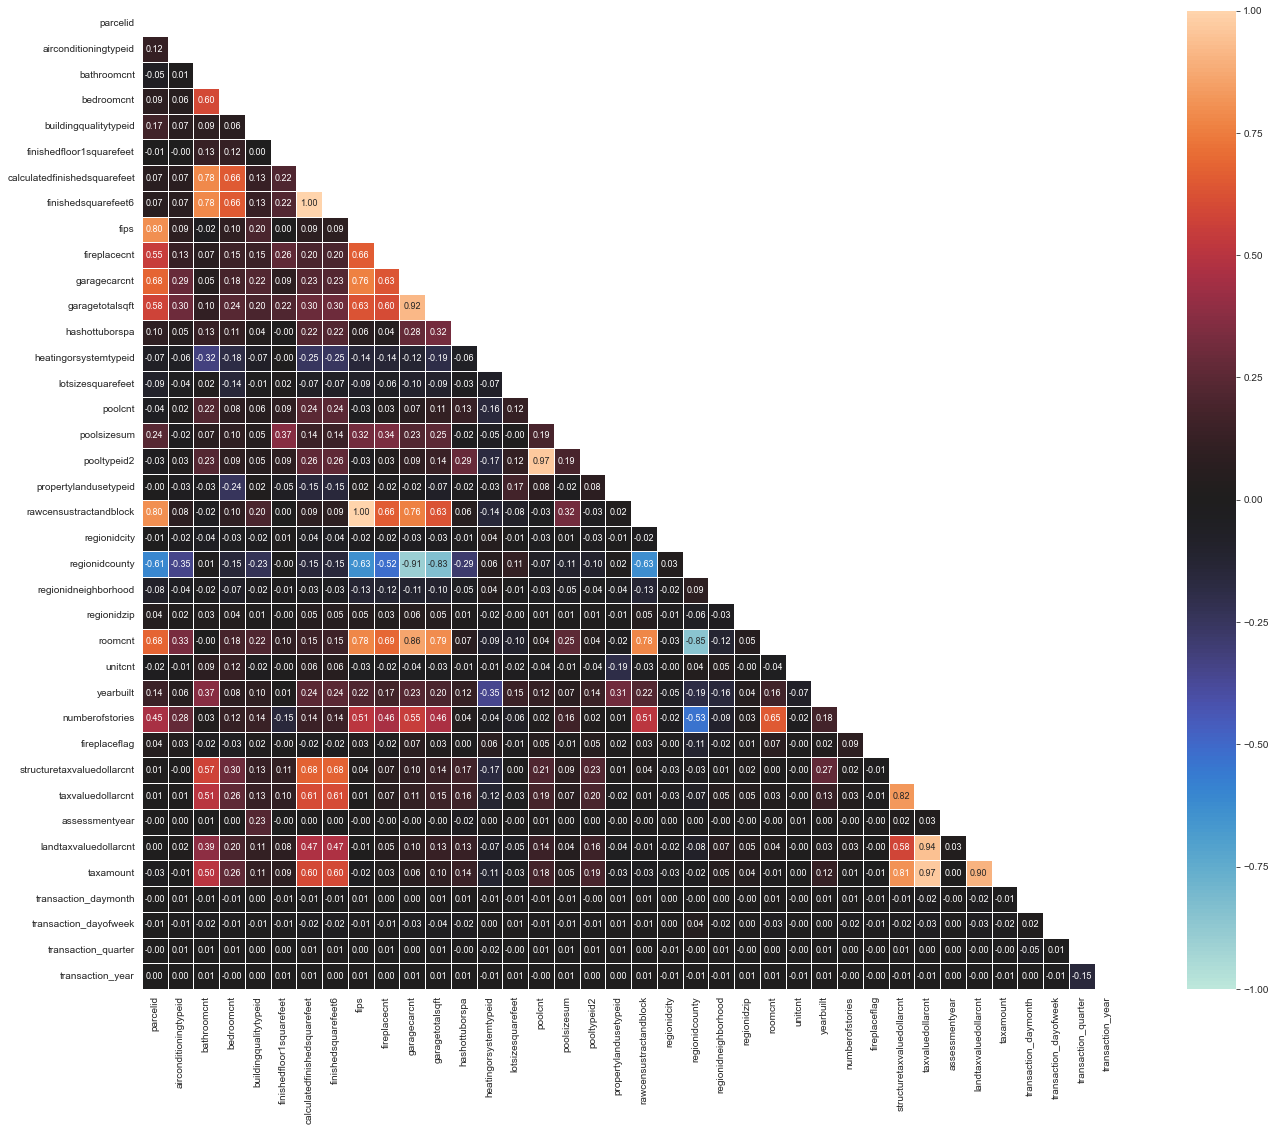

In [180]:
# Compute the correlation matrix
corr = X_train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.close("all")
f, ax = plt.subplots(figsize=(24, 18))

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask, vmax=1.0, vmin=-1.0, center=0, square=True, annot=True, fmt=".2f", annot_kws={"size": 9},
           linewidths=.5)

We note from the heatmap that some columns seems to be highly correlated: I'll set a threshold and I'll leave on the dataset only one column between each correlated group, and I choose to keep the column with less NaN.
This is a process that can't be automated too much because someone (myself) need to understand the groups of correlated variables (based on columns names), making sure is not spurious correlation (for example `regionidcounty` and `garagecount`)

In [181]:
t = Texttable()
t.add_rows([["row", "column", "correlation"]])
threshold = 0.85

for r in corr.columns:
    for c in corr.columns:
        if abs(corr.loc[r, c]) >= threshold and corr.columns.get_loc(r) > corr.columns.get_loc(
                c):  # check also to take only values under the main diagonal (to avoid repetitions)
            t.add_row([r, c, corr.loc[r, c]])

print(t.draw())

+------------------------+------------------------------+-------------+
|          row           |            column            | correlation |
+========================+==============================+=============+
| finishedsquarefeet6    | calculatedfinishedsquarefeet | 1.000       |
+------------------------+------------------------------+-------------+
| garagetotalsqft        | garagecarcnt                 | 0.916       |
+------------------------+------------------------------+-------------+
| pooltypeid2            | poolcnt                      | 0.969       |
+------------------------+------------------------------+-------------+
| rawcensustractandblock | fips                         | 1.000       |
+------------------------+------------------------------+-------------+
| regionidcounty         | garagecarcnt                 | -0.905      |
+------------------------+------------------------------+-------------+
| roomcnt                | garagecarcnt                 | 0.861 

So the groups can be:
- finishedsquarefeet6, calculatedfinishedsquarefeet
- garagetotalsqft, garagecarcnt
- pooltypeid2, poolcnt
- rawcensustractandblock, fips
- landtaxvaluedollarcnt, taxvaluedollarcnt, taxamount

For each of them, I'll take the one with more non-NaN value and keep only it

In [182]:
groups = [
    ['finishedsquarefeet6', 'calculatedfinishedsquarefeet'],
    ['pooltypeid2', 'poolcnt'],
    ['garagetotalsqft', 'garagecarcnt'],
    ['rawcensustractandblock', 'fips'],
    ['landtaxvaluedollarcnt', 'taxvaluedollarcnt', 'taxamount']
]
to_drop = []

print(f"#columns before: {X_train.shape[1]}")

for g in groups:
    min_nan = X_train.shape[0]
    to_keep = ""
    #print(f"GROUP {g}")
    for el in g:
        #print(f"{el}: {X_train[el].isna().sum()} nan")
        if X_train[el].isna().sum() < min_nan:
            min_nan = X_train[el].isna().sum()
            to_keep = el
    g.remove(to_keep)
    #print(f"REMOVE: {g}")
    for c in g:
        to_drop.append(c)
X_train.drop(columns=to_drop, inplace=True)
dropped.append(to_drop)

print(f"#columns after: {X_train.shape[1]}")

#columns before: 38
#columns after: 32


### Distribution charts for dates

In [183]:
categorical_columns = ['airconditioningtypeid', 'buildingqualitytypeid', 'hashottuborspa', 'heatingorsystemtypeid',
                       'pooltypeid2', 'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity',
                       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'fireplaceflag']
numerical_columns = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'finishedsquarefeet6', 'fireplacecnt',
                     'garagetotalsqft', 'lotsizesquarefeet', 'poolsizesum', 'roomcnt', 'unitcnt',
                     'numberofstories', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt']
dates_columns = ['transaction_daymonth', 'transaction_dayofweek', 'transaction_quarter',
                 'transaction_year', 'assessmentyear', 'yearbuilt']

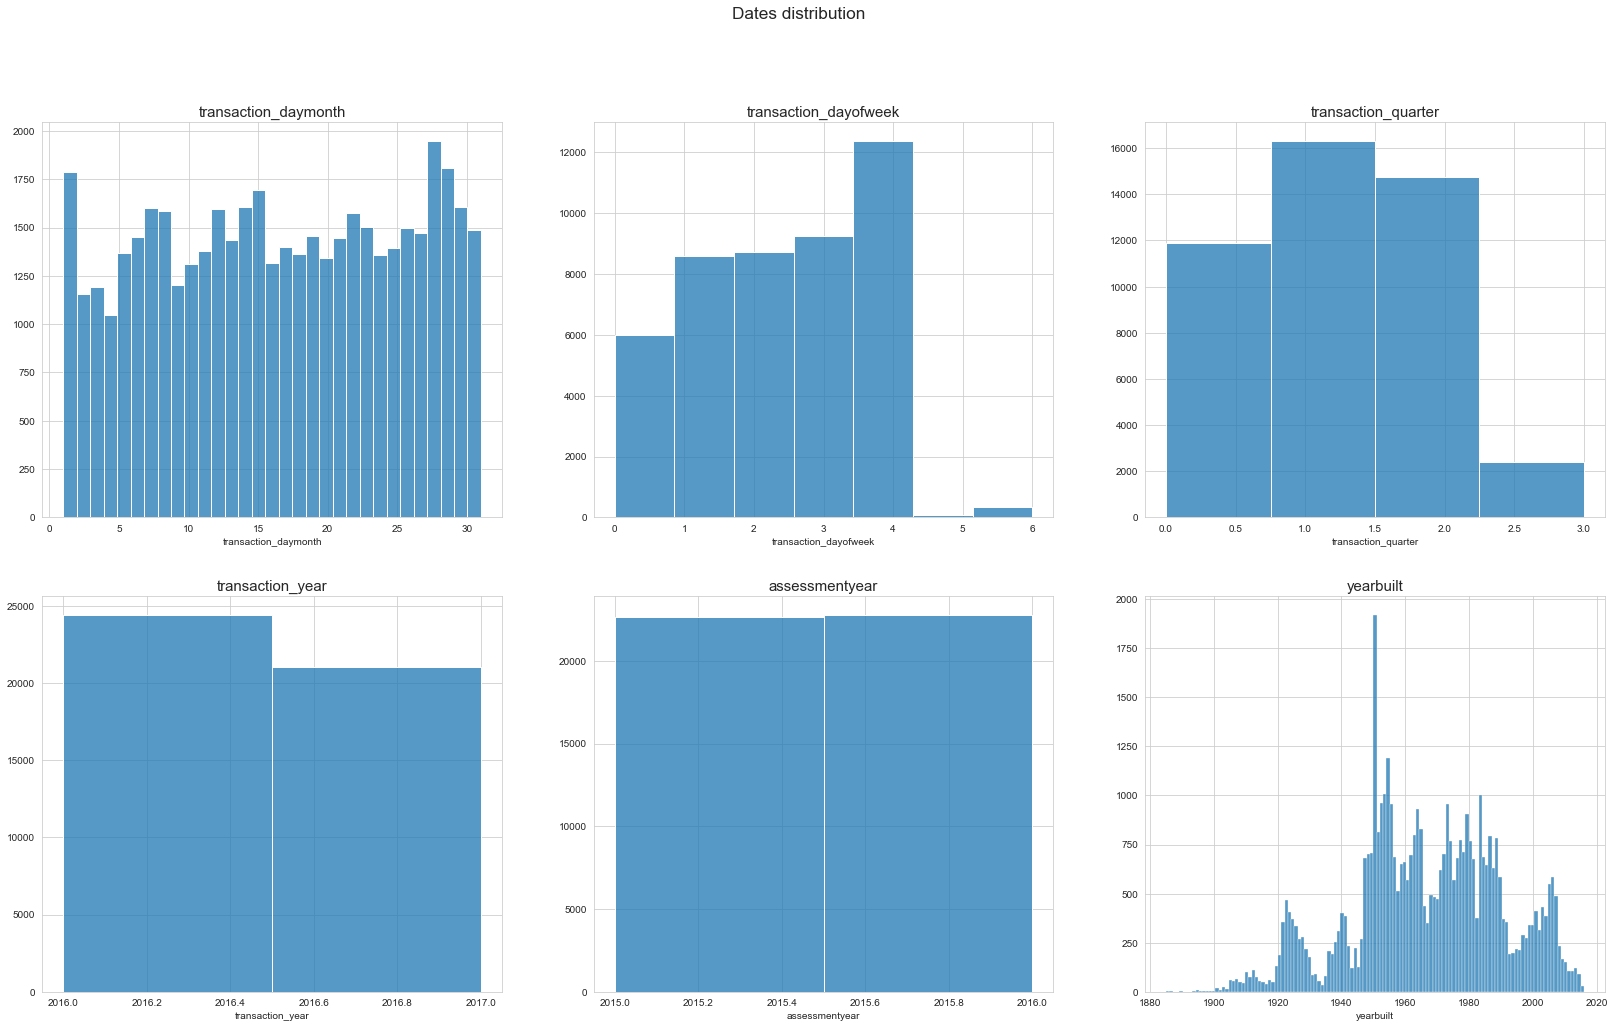

In [184]:
i = 0
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(28, 16))
fig.suptitle('Dates distribution', size='xx-large')

for col in dates_columns:
    b = sb.histplot(ax=ax[i//3, i % 3], data=X_train[col], kde=False, bins=X_train[col].nunique())
    b.axes.set_title(col, fontsize=15)
    b.set_ylabel("", fontsize=15)
    i += 1

I'll handle dates as numeric features


### Distributions charts for numerical columns
Let's visualize the distribution of each column, in order to understand how data is distributed and if there are outliers through a boxplot

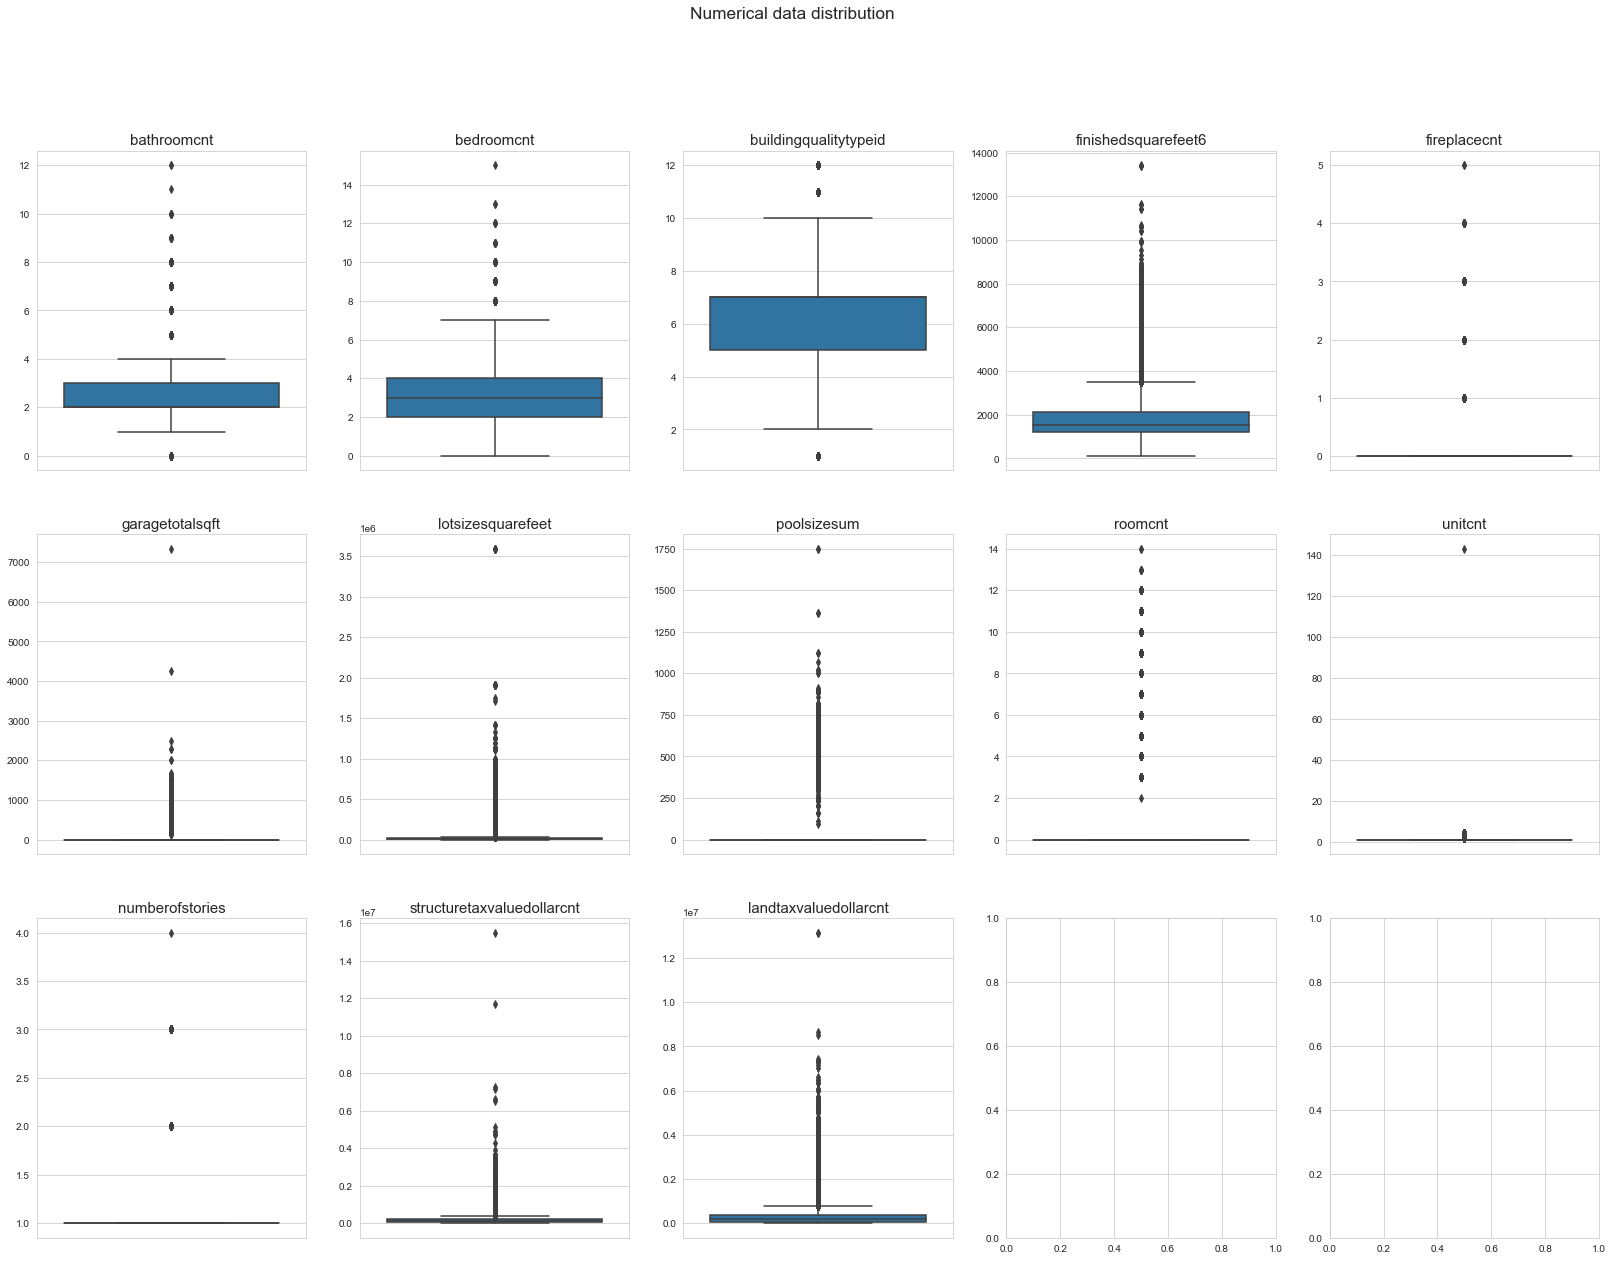

In [185]:
i = 0
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(28, 20))
fig.suptitle('Numerical data distribution', size='xx-large')

for col in numerical_columns:
    b = sb.boxplot(ax=ax[i // 5, i % 5], y=X_train[col])
    b.axes.set_title(col, fontsize=15)
    b.set_ylabel("", fontsize=15)
    i += 1

We can observe that many features has many concentrated values with some outliers, and this is also because of the filling of NaN that I done before, that takes the mean or mode

### Distribution charts and number of levels for categorical data
For categorical columns, let's visualize the distribution of data

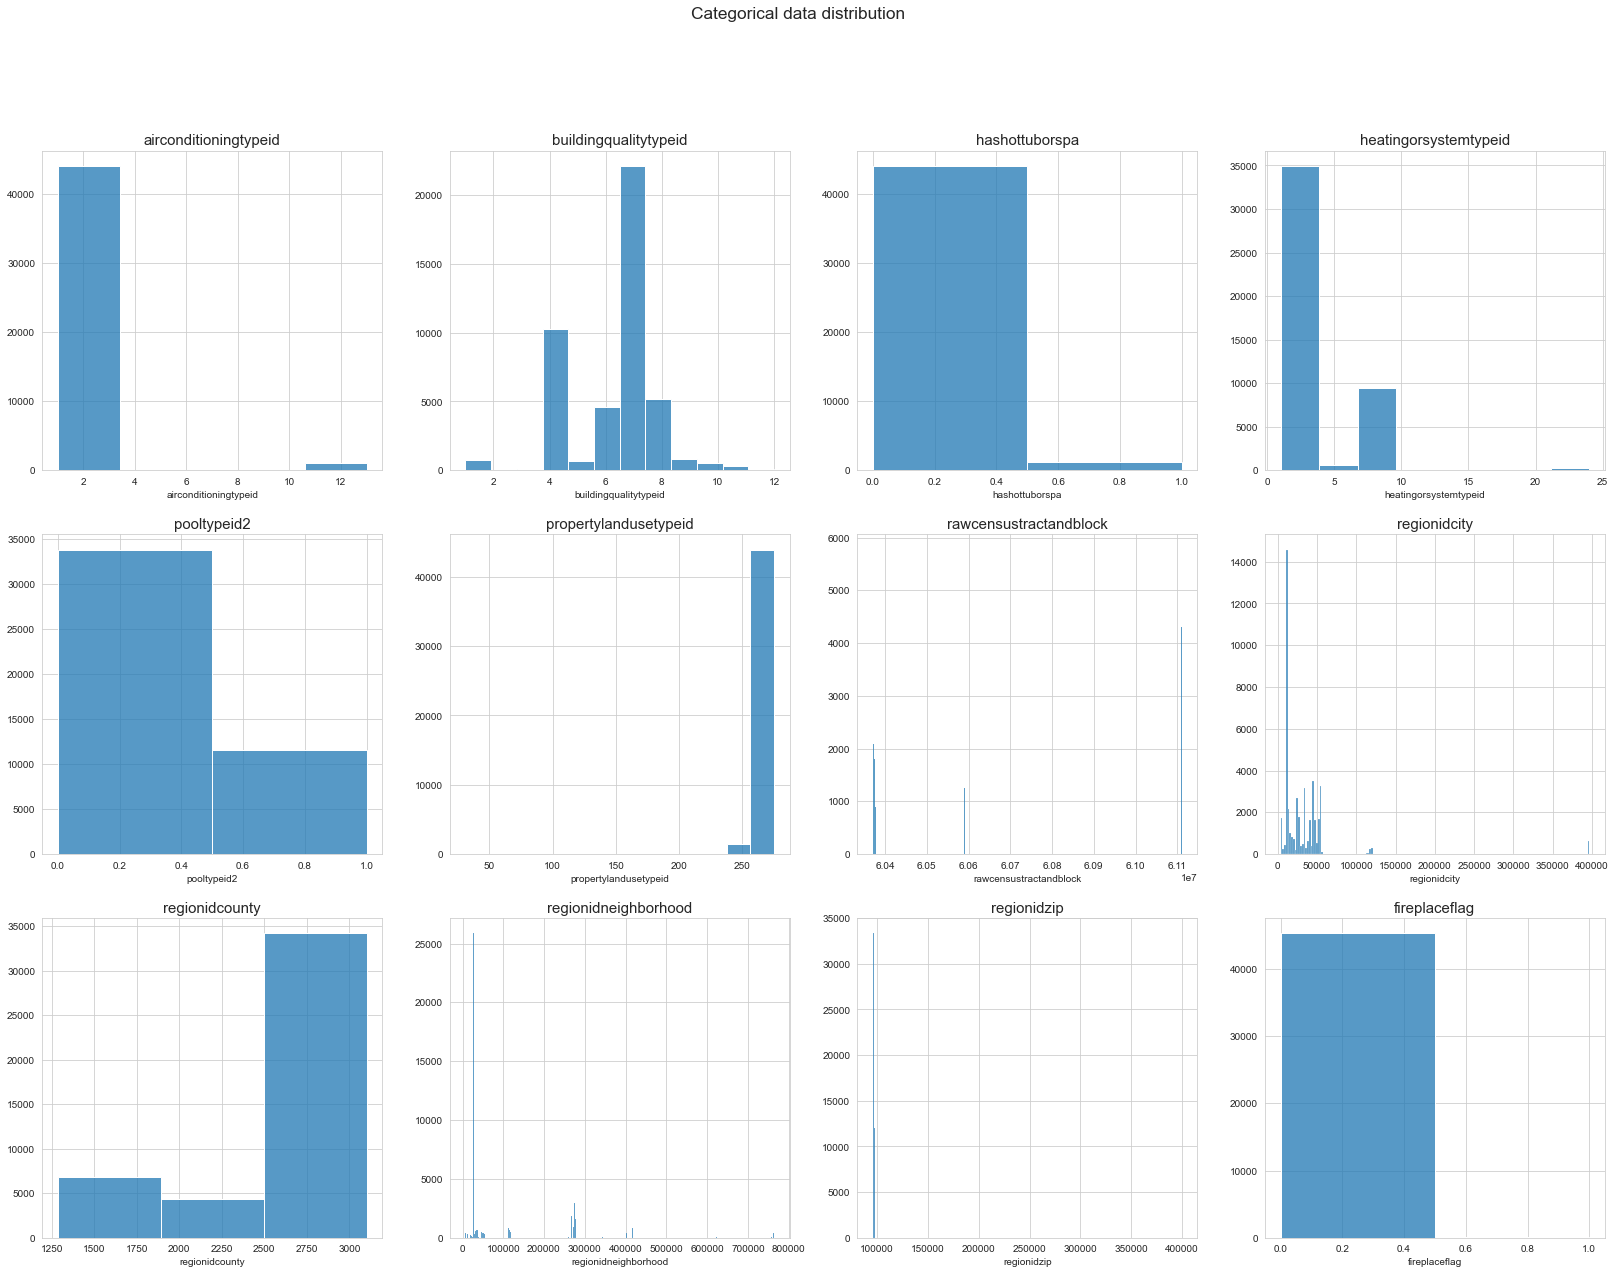

In [186]:
i = 0
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(28, 20))
fig.suptitle('Categorical data distribution', size='xx-large')

for col in categorical_columns:
    b = sb.histplot(ax=ax[i // 4, i % 4], data=X_train[col], kde=False, bins=X_train[col].nunique())
    b.axes.set_title(col, fontsize=15)
    b.set_ylabel("", fontsize=15)
    i += 1

 We already have an idea of the number of levels for categorical columns from the above graphs, let’s visualize the precise number of levels, in order to have an idea if it's feasible to perform one-hot-encoding

In [187]:
X_train.loc[:, categorical_columns].nunique()

airconditioningtypeid        5
buildingqualitytypeid       12
hashottuborspa               2
heatingorsystemtypeid        8
pooltypeid2                  2
propertylandusetypeid       13
rawcensustractandblock    1392
regionidcity               174
regionidcounty               3
regionidneighborhood       437
regionidzip                382
fireplaceflag                2
dtype: int64

It seems feasible to realize the one hot eoncoding only on columns that has a low number of levels: let's set a threshold and take only the categorical columns that has less than threshold levels to perform one hot encoding.

Another method can be to take all columns and perform one hot encoding only on the most frequent levels, however looking at the columns with lot of levels, it seems that aren't really good predictor for the price of a home (for example we can have lot of different types of houses in the same city or region). Anyhow it can be an idea for a future model comparison.

## One hot encoding where possible, drop otherwise
Let's set a threshold and take only the categorical columns that has less than threshold levels to perform one hot encoding.

In [188]:
threshold = 10
to_encode = []
to_drop = []
print(f"#columns before {X_train.shape[1]}")

for col in X_train.columns:
    if col in categorical_columns:
        if X_train.nunique()[col] < threshold:
            to_encode.append(col)
        else:
            to_drop.append(col)
# One-Hot-Encoding with pandas
# X = pd.get_dummies(X, columns=to_encode, drop_first=False, dtype='int32') # drop_first=False to ensure to still have a possible encoding for new values that are not present in X_train

# One-Hot_encoding with sklearn
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded = ohe.fit_transform(X_train[to_encode])
X_train[ohe.get_feature_names_out()] = encoded
X_train.drop(columns=to_encode, inplace=True)

print(f"#columns after {X_train.shape[1]}")
# don't drop here because I need columns for next cell
#print(f"#columns after {X_train.shape[1]}")

#columns before 32
#columns after 48


## Adding a new feature
As mentioned earlier, the categorical feature on which I cannot do one-hot-encoding will be removed; but before we can still extrapolate some information from them. For example let's take `regionidneighborhood`, that has a lot of levels. We can introduce a new feature for each row that is the mean of a certain feature for the houses in that neighborhood; I selected `finishedsquarefeet6`, that seems a relevant feature for price evaluation. I'll call the new feature `neighborhood_sqft_mean`. Indeed we can imagine that the price of the house is influenced by the neighborhood condition; a neighborhood with big houses is more prestigious than one with small houses.
Of course it's not always true but it's a way to try to save the utility of that variabile, instead of simply dropping it.

In [189]:
neigh_sqft_mean = dict()
for neigh in X_train.regionidneighborhood.unique():
    neigh_sqft_mean[neigh] = round(
        X_train[X_train.regionidneighborhood == neigh][
            'finishedsquarefeet6'].mean())  # mean of sqft for each neighborhood
X_train['neighborhood_sqft_mean'] = X_train.apply(lambda row: neigh_sqft_mean[row['regionidneighborhood']], axis=1)

# Drop column in which is infeasible to perform one-hot-encoding
X_train.drop(columns=to_drop, inplace=True)
dropped.append(to_drop)

## Remove `parcelid` since I don't need it anymore

In [190]:
X_train.drop(columns=['parcelid'], inplace=True)
dropped.append('parcelid')

## Scale data
Scaling data can be interpreted as giving the same importance to all features. Not all the algorithms require in input scaled data in order to work properly.
For now I won't scale data, and that'll be a responsibility of the used algorithm, depending on if it need it.
Anyhow I write here the code that can be used for this purpose



In [191]:
# Se ci fosse bisogno userei lo StandardScaler, dato che non definisce minimo e massimo
def scale(X_train, X_valid, X_test):
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    return scaler.transform(X_train), scaler.transform(X_valid), scaler.transform(X_test)

## Repeat whole cleaning process in a function

The function below is the summary of the decisions taken based on the analysis made and and the related actions that reflect on the dataset.
The columns to drop are hard-coded and reflects the above analysis.

In [192]:
def cleaning_process(X, encoder): # the same encoder that was used for training is required
    to_drop = [['pooltypeid10', 'pooltypeid7', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
                'finishedsquarefeet50', 'calculatedbathnbr', 'fullbathcnt', 'threequarterbathnbr', 'latitude',
                'longitude', 'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid',
                'storytypeid', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26',
                'taxdelinquencyflag', 'taxdelinquencyyear', 'propertycountylandusecode', 'propertyzoningdesc',
                'censustractandblock', 'calculatedfinishedsquarefeet', 'poolcnt', 'garagecarcnt',
                'fips', 'taxvaluedollarcnt', 'taxamount', 'rawcensustractandblock', 'regionidcity', 'regionidzip',
                'parcelid', 'buildingqualitytypeid', 'propertylandusetypeid'], ['regionidneighborhood',
                              'transactiondate']]  # based on the behaviour of the Data Analysis process on the train dataset. It is composed by two lists, that correspond to [0]: the columns that can be dropped before and [1]: the columns that must be dropoed at the end of the process
    fill_zero = ['fireplacecnt', 'fireplaceflag', 'garagecarcnt', 'garagetotalsqft',
                 'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid2']
    fill_zero = [c for c in fill_zero if c not in to_drop[0]]  # remove useless cols
    # print(f"FILL_ZERO: {fill_zero}")
    fill_categorical = ['airconditioningtypeid', 'buildingqualitytypeid', 'fips', 'heatingorsystemtypeid',
                        'propertycountylandusecode', 'propertylandusetypeid',
                        'propertyzoningdesc', 'rawcensustractandblock', 'censustractandblock', 'regionidcounty',
                        'regionidcity', 'regionidzip', 'regionidneighborhood',
                        'unitcnt']
    fill_categorical = [c for c in fill_categorical if c not in to_drop[0]]
    # print(f"FILL_CATEGORICAL: {fill_categorical}")
    fill_numerical = ['bathroomcnt', 'bedroomcnt', 'finishedfloor1squarefeet',
                      'calculatedfinishedsquarefeet', 'finishedsquarefeet6', 'lotsizesquarefeet', 'numberofstories',
                      'roomcnt', 'yearbuilt', 'taxvaluedollarcnt', 'structuretaxvaluedollarcnt',
                      'landtaxvaluedollarcnt', 'taxamount', 'assessmentyear']
    fill_numerical = [c for c in fill_numerical if c not in to_drop[0]]
    # print(f"FILL_NUMERICAL: {fill_numerical}")
    to_encode = ['airconditioningtypeid', 'hashottuborspa', 'heatingorsystemtypeid', 'pooltypeid2', 'regionidcounty', 'fireplaceflag']


    # DROP part of WHAT I CLASSIFIED BEFORE AS USELESS
    X.drop(columns=to_drop[0], inplace=True)

    # FILL NAN
    for c in fill_zero:
        X[c].fillna(value=0, inplace=True)
    for c in fill_numerical:
        X[c].fillna(value=round(X[c].mean()), inplace=True)
    for c in fill_categorical:
        X[c].fillna(value=X[c].mode()[0], inplace=True)

    # TYPE CAST
    for c in X.columns:
        if X[c].dtype == 'int64' or X[c].dtype == 'float64':
            # print(f"convert {col} to int32")
            X[c] = X[c].astype('int32')
        else:
            # print(f"skip {col}")
            continue

    # OBJECT HANDLE
    X.hashottuborspa = X.hashottuborspa.astype('int32')
    X.fireplaceflag = X.fireplaceflag.astype('int32')

    X['transaction_daymonth'] = X.apply(lambda row: datetime.strptime(row['transactiondate'], '%Y-%m-%d').day,
                                        axis=1)
    X['transaction_dayofweek'] = X.apply(
        lambda row: datetime.strptime(row['transactiondate'], '%Y-%m-%d').weekday(),
        axis=1)
    X['transaction_quarter'] = X.apply(
        lambda row: (datetime.strptime(row['transactiondate'], '%Y-%m-%d').month - 1) // 3, axis=1)
    X['transaction_year'] = X.apply(lambda row: datetime.strptime(row['transactiondate'], '%Y-%m-%d').year,
                                    axis=1)
    # PERFROM ONE-HOT-ENCODING
    encoded = ohe.transform(X[to_encode])
    X[ohe.get_feature_names_out()] = encoded
    X.drop(columns=to_encode, inplace=True)

    # NEW FEATURE
    neigh_sqft_mean = dict()
    for neigh in X.regionidneighborhood.unique():
        neigh_sqft_mean[neigh] = round(
            X[X.regionidneighborhood == neigh][
                'finishedsquarefeet6'].mean())  # mean of sqft for each neighborhood
    X['neighborhood_sqft_mean'] = X.apply(lambda row: neigh_sqft_mean[row['regionidneighborhood']], axis=1)

    # DROP other part of WHAT I CLASSIFIED BEFORE AS USELESS
    X.drop(columns=to_drop[1], inplace=True)

    return X

For example, we need to apply the same cleaning done in train also in validation and test. Let's do it:

In [193]:
X_valid = cleaning_process(X_valid, ohe)
X_test = cleaning_process(X_test, ohe)

## Export modified dataset
Here we export the modified dataset that are ready for model creation, in order to have a simple access from other notebooks that serve this purpose.

In [200]:
X_train.to_csv('../DWMProjectData/formodel/X_train.csv', index=False)
y_train.to_csv('../DWMProjectData/formodel/y_train.csv', index=False)
X_valid.to_csv('../DWMProjectData/formodel/X_valid.csv', index=False)
y_valid.to_csv('../DWMProjectData/formodel/y_valid.csv', index=False)
X_test.to_csv('../DWMProjectData/formodel/X_test.csv', index=False)
y_test.to_csv('../DWMProjectData/formodel/y_test.csv', index=False)

# IDEAS AND RESOURCES
`yardbuildingsqft17`, `yardbuildingsqft26` si potrebbe vedere assieme quanti missing hanno???


Useful resources:
- https://stackoverflow.com/questions/15819050/pandas-dataframe-concat-vs-append
- https://levelup.gitconnected.com/importance-of-data-preprocessing-and-scaling-in-machine-learning-21db1d4377ec on how to scale
- https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i on how to apply the scale


print(properties.columns[ properties.isna().any()].tolist()) # colonne che hanno almeno un valore null

properties.loc[:,group_pool].dropna(how='all') # per vedere righe che hanno almeno un valore non nullo nelle colonne indicate

print(set(X_train.columns.to_list()) - set(X_test.columns.to_list()))
